# Porfolio Optimization




#### Variance

- Variance measures the dispersion of an asset's returns around its mean (expected return). It measures individual asset risk.

- Formula: for an assert with random return $r_i$ and expected return $\mu_i$: $\sigma_i^2=\text{Var}(r_i)=\mathbb{E}[(r_i-\mu_i)^2]$.

- Higher variance → Higher risk (more volatile returns).


#### Covariance

- Covariance measures the directional relationship between two assets' returns. It tells whether they tend to move in the same direction (positive covariance) or opposite diretions (negative covariance).

- Formula: for two assets $r_i$ and $r_j$: $\sigma_{ij}=\text{Cov}(r_i,r_j)=\mathbb{E}[(r_i-\mu_i)(r_j-\mu_j)]$.

- Combining assets with negative/low covariance reduces overall portfolio risk.


#### Portfolios

Assume $n$ assets with expected return $\mu$ and covariance matrix $\Sigma$.
The return and variance of a portfolio that invests in these $n$ assets with weight $w$ are: $\mu_p=w^T \mu$ and $\sigma_p^2=w^T \Sigma w$.

Assume two portfolios of respective weights $w_1$ and $w_2$. The covariance between these two portfolios is $\rho_{12}=cov(w_1^T\mu,w_2^T\mu)=w_1^T\Sigma w_2$.

<br>
Reference:

https://letianzj.github.io/portfolio-management-one.html


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from datetime import datetime, date

### Load Data

In [3]:
# Load data
assets = [
    'AAPL',  # Apple
    'KO',    # Coca-Cola
    'DIS',   # Disney
    'XOM',   # Exxon Mobil
    'JPM',   # JPMorgan Chase
    'MCD',   # McDonald's
    'WMT',   # Walmart
]

hist_data = pd.DataFrame()
start_data = '2015-01-01'
end_data = '2017-12-31'
for i in range(len(assets)):
  asset = assets[i]
  data = pd.read_csv("data/" + asset + ".csv")
  mask1 = data['Date'] >= start_data
  mask2 = data['Date'] <= end_data
  data = data[mask1 & mask2]
  if i == 0:
    hist_data['Date'] = data['Date']
    hist_data[asset] = data['Adj Close']
  else:
    hist_data = pd.merge(hist_data, data[['Date', 'Adj Close']], on='Date', how='left')
    hist_data.rename(columns={'Adj Close': asset}, inplace=True)

# Check nan
assert hist_data.isna().sum().sum() == 0

hist_data.shape

(755, 8)

In [4]:
hist_data.head()

,Date,AAPL,KO,DIS,XOM,JPM,MCD,WMT
0,2015-01-02,100.216454,35.491245,87.376266,75.439079,54.462791,80.689468,75.466400
1,2015-01-05,97.393181,35.491245,86.099403,73.374931,52.771992,79.798302,75.246773
2,2015-01-06,97.402374,35.760750,85.642708,72.984848,51.403664,79.945404,75.826607
3,2015-01-07,98.768150,36.207142,86.518814,73.724373,51.482113,81.338379,77.838448
4,2015-01-08,102.563072,36.645096,87.413536,74.951500,52.632545,81.641197,79.481316


### Compute log returns, mean, variance and covariance

In [5]:
# Calculate historical log returns
cols = hist_data.columns[1:]
hist_return = np.log(hist_data[cols] / hist_data.shift()[cols])
hist_return.dropna(inplace=True)

In [6]:
hist_return.head()

,AAPL,KO,DIS,XOM,JPM,MCD,WMT
1,-0.028576,0.000000,-0.014721,-0.027743,-0.031537,-0.011106,-0.002915
2,0.000094,0.007565,-0.005318,-0.005330,-0.026271,0.001842,0.007676
3,0.013925,0.012405,0.010178,0.010082,0.001525,0.017274,0.026186
4,0.037703,0.012023,0.010288,0.016508,0.022100,0.003716,0.020886
5,0.001072,-0.011093,0.004892,-0.001411,-0.017540,-0.012262,-0.012457


In [8]:
# Find historical mean, covariance, and correlation
hist_mean = hist_return.mean(axis=0).to_frame()
hist_mean.columns = ['mu']
hist_cov = hist_return.cov()
hist_corr = hist_return.corr()

print(f"Historical average daily return: \n{hist_mean.transpose()}\n\n")
print(f"Historical daily return covariance: \n{hist_cov}\n\n")
print(f"Historical daily return correlation: \n{hist_corr}\n\n")

Historical average daily return: 
        AAPL        KO       DIS       XOM       JPM       MCD       WMT
mu  0.000652  0.000242  0.000238  0.000002  0.000816  0.000932  0.000293


Historical daily return covariance: 
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  0.000208  0.000032  0.000055  0.000051  0.000076  0.000044  0.000038
KO    0.000032  0.000065  0.000030  0.000033  0.000032  0.000035  0.000030
DIS   0.000055  0.000030  0.000138  0.000048  0.000072  0.000032  0.000031
XOM   0.000051  0.000033  0.000048  0.000132  0.000080  0.000036  0.000028
JPM   0.000076  0.000032  0.000072  0.000080  0.000180  0.000051  0.000038
MCD   0.000044  0.000035  0.000032  0.000036  0.000051  0.000101  0.000032
WMT   0.000038  0.000030  0.000031  0.000028  0.000038  0.000032  0.000150


Historical daily return correlation: 
          AAPL        KO       DIS       XOM       JPM       MCD       WMT
AAPL  1.000000  0.277773  0.324263  0.308124  0.390764  0.305937  

### Generate synthetic portfolios

Use Monte Carlo simulaton to construct 5,000 portfolios with random generated weights $w$.

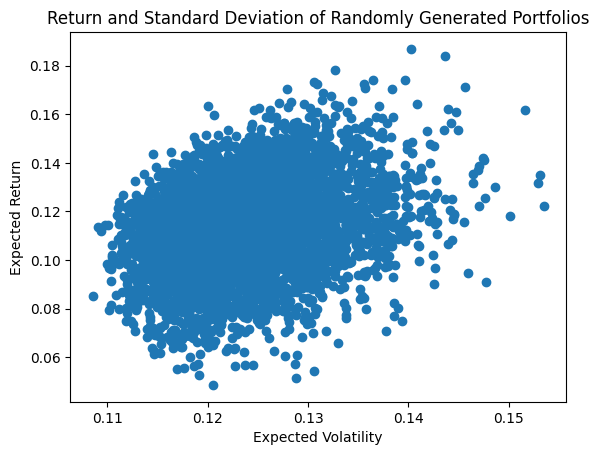

In [29]:
# Construct random portfolios
n_portfolios = 5000

# Results placeholders
port_returns = np.zeros(n_portfolios)
port_stds = np.zeros(n_portfolios)

for i in range(n_portfolios):
  w = np.random.random(len(assets)) # generate random weights
  w /= np.sum(w) # normalize so that weights sum equal to one
  port_return = np.dot(w.T, hist_mean.values) * 250 # annualize; 250 business days
  port_std = np.sqrt(np.dot(w.T, np.dot(hist_cov, w)) * 250) # annualize; 250 business days
  port_returns[i] = port_return.item()
  port_stds[i] = port_std.item()

# Plot
plt.plot(port_stds, port_returns, 'o',markersize=6)
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Return and Standard Deviation of Randomly Generated Portfolios')
plt.show()

Some portfolios are superior to others, achieving higher returns at the cost of lower risks.

### Global Minimum Variance (GMV)

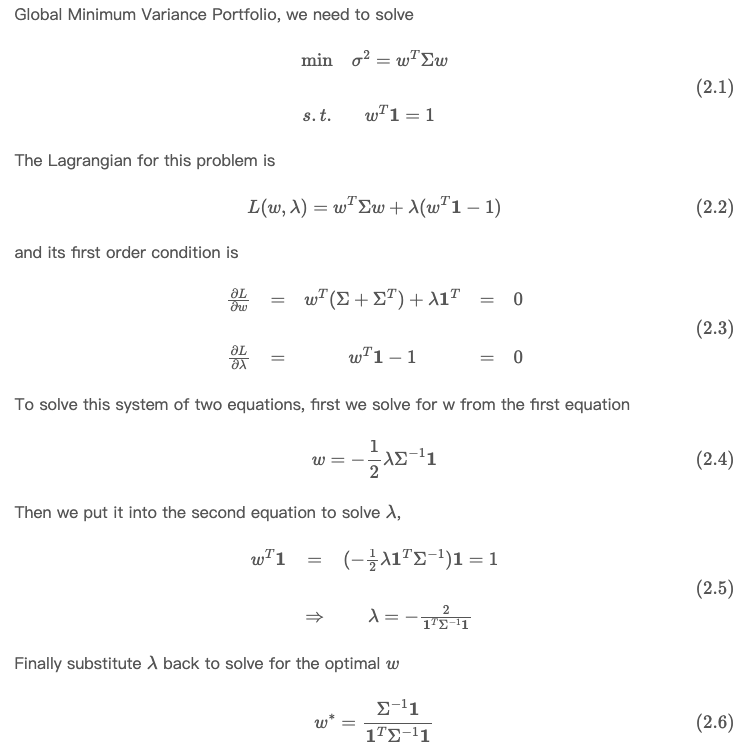

#### Closed-form of Global Minimum Variance (GMV)

In [59]:
# Closed-form of Global Minimum Variance (GMV)
hist_cov_inv = np.linalg.inv(hist_cov)
one_vec = np.ones(len(assets))
w_gmv = np.dot(hist_cov_inv, one_vec) / (np.dot(np.transpose(one_vec), np.dot(hist_cov_inv, one_vec)))
w_gmv_df = pd.DataFrame(data=w_gmv).transpose()
w_gmv_df.columns = assets
std_gmv = np.sqrt(np.dot(np.transpose(w_gmv), np.dot(hist_cov, w_gmv))) * np.sqrt(250)
print("GMV weights: \n", w_gmv_df, "\n")
print("GMV standard deviation: \n", std_gmv)

GMV weights: 
        AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.037909  0.426967  0.125357  0.115102 -0.014228  0.179355  0.129538 

GMV standard deviation: 
 0.10748252656948809


#### Numerical solution: use Python quadratic solver

https://cvxopt.org/userguide/coneprog.html#cvxopt.solvers.qp

https://cvxopt.org/examples/book/portfolio.html

In [62]:
# Numerical solution
P = matrix(hist_cov.values)
q = matrix(np.zeros((len(assets), 1)))
A = matrix(1.0, (1, len(assets)))
b = matrix(1.0)

w_gmv_v2 = np.array(solvers.qp(P, q, A=A, b=b)['x'])
w_gmv_v2_df = pd.DataFrame(w_gmv_v2).transpose()
w_gmv_v2_df.columns = assets
std_gmv_v2 = np.sqrt(np.dot(np.transpose(w_gmv_v2), np.dot(hist_cov, w_gmv_v2))) * np.sqrt(250)
print("GMV weights: \n", w_gmv_v2_df, "\n")
print("GMV standard deviation: \n", std_gmv_v2.item())

GMV weights: 
        AAPL        KO       DIS       XOM       JPM       MCD       WMT
0  0.037909  0.426967  0.125357  0.115102 -0.014228  0.179355  0.129538 

GMV standard deviation: 
 0.10748252656948813


Both methods yield the same optimal weights.